In [1]:
import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime

### Yfinance y plots de opciones

In [2]:
## voy a definir una funcion que baje los calls y puts de un ticker
def generar_df_opciones(ticker):

    ## instancio el ticker
    data = yf.Ticker(ticker)

    ## me traigo los vencimientos
    vencimientos = data.options

    ## los calls para ese vencimiento
    calls = [data.option_chain(x)[0] for x in vencimientos]
    calls = pd.concat(calls)

    ## los puts para ese vencimiento
    puts = [data.option_chain(x)[1] for x in vencimientos]
    puts = pd.concat(puts)

    ## uno ambos
    opciones = pd.concat([calls,puts]).reset_index(drop = True)
    ## le agrego el spot
    opciones.loc[:,"spot"] = data.history().Close.values[-1]
    
        
    ## le agrego el ticker
    opciones.loc[:,"ticker"] = ticker
    
    return opciones

In [3]:
## defino una funcion que, a partir del dataframe de base, me devuelva un df completo
## con toda la data que pide maurette
def get_full_data(df):
    callput = df.iloc[:,0].str[10]
    df.loc[:,"CallPut"] = callput

    ## tomo 4to y 5to del ticker de la opcion
    ## la convierto en int y le sumo 2020, con eso obtengo el año
    year = 2000 + df.iloc[:,0].str[4:6].astype(int)

    ## tomo la posicion 6 y 7 del ticker para el mes
    month = df.iloc[:,0].str[6:8].astype(int)

    ## tomo la posicion 8 y 9 del ticker para el dia
    day = df.iloc[:,0].str[8:10].astype(int)

    ## voy a tomar la fecha de hoy y se la voy a restar la fecha de vencimiento, 
    ## con eso obtengo el time to maturity
    hoy = datetime.date.today()

    ## zip lo que hace es unir año, mes y dia. Cuando itera me devuelve le primer año de la lista
    ## con el primer mes de la lista con el primer día de la lista. 
    ## Despues el segundo año de la lista, con el segundo mes, con el segundo día y así.
    ## para cada uno de estos genero una fecha
    expiry_datetime = [datetime.date(y, m, d) for y,m,d in zip(year, month, day)]

    ## y para cada fecha, le resto la fecha de hoy
    ttm = [(d - hoy).days for d in expiry_datetime]
    df.loc[:,"ttm"] = ttm

    ## defino moneyness como el ratio entre el spot y el strike
    df.loc[:,"moneyness"] = df.spot/df.strike
    
    ## reordeno las columnas
    df = df.iloc[:,[0,-4,-5,-3,2,-2, 3, 4, 5, 10, -1]]
    df.columns = ["Especie", "Ticker", "Spot", "CallPut","Strike", "TTM", "Last", "Bid", 
                  "Ask", "impliedVolatility","Moneyness"]
    return df

In [4]:
ticker = "GGAL"
ggal = generar_df_opciones(ticker)
ggal = get_full_data(ggal)

#### Gráficos

In [5]:
## definimos una funcion para graficar el precio contra el strike

def graficar_strike_precio(df, CP="C", TTMs = None):
    
    if TTMs is None:
        TTMs = df.TTM.unique()
    for TTM in TTMs:
        ## para un time to maturity tomo los strikes de los calls
        Ks = df[(df.TTM == TTM) & (df.CallPut == CP)].Strike
        ## para un time to maturity tomo los precios
        precios = df[(df.TTM == TTM) & (df.CallPut == CP)].Last
        ## ploteo
        plt.plot(Ks, precios,'*', label='TTM = '+str(TTM))


    plt.legend()

    plt.xlabel('Strike')
    
    tipo_opcion = "Call" if CP == "C" else "Put"
    plt.ylabel(f'Precio de mercado del {tipo_opcion}')
    plt.title(f'Precio de mercado de las opciones {tipo_opcion} con respecto al Strike')

    plt.show()


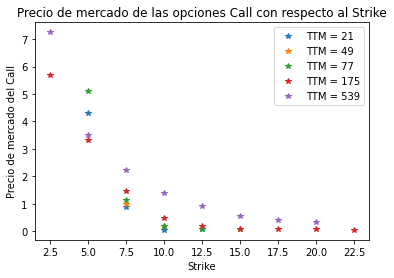

In [6]:
## graficamos Strike contra precio de mercado del call para cada time to maturity
## a mismo ttm, cuantoi mas alto el strike, mas barato el call
graficar_strike_precio(ggal,"C")


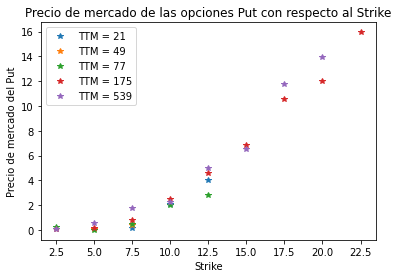

In [7]:
## lo mismo pero para puts.
## vemos que a mayor strike, mayor precio del put
graficar_strike_precio(ggal,"P")

In [8]:
## defino una funcion para plotear el ttm contra el precio

def graficar_ttm_precio(df, CP="C", Ks=None):
    plt.figure(figsize=(18,10))
    
    if Ks is None:
        Ks = df.Strike.unique()
    for K in Ks:
        TTMs = df[(df.Strike == K) & (df.CallPut == CP)].TTM.values
        precios = df[(df.Strike == K) & (df.CallPut == CP)].Last.values
        if len(TTMs)>1:
            plt.plot(TTMs, precios,'*', label='Strike = '+str(K))

    plt.legend()

    plt.xlabel('TTM')
    plt.ylabel('Precio de mercado del Call')
    plt.title('Precio de mercado de las opciones Call con respecto al TTM')

    plt.show()
    

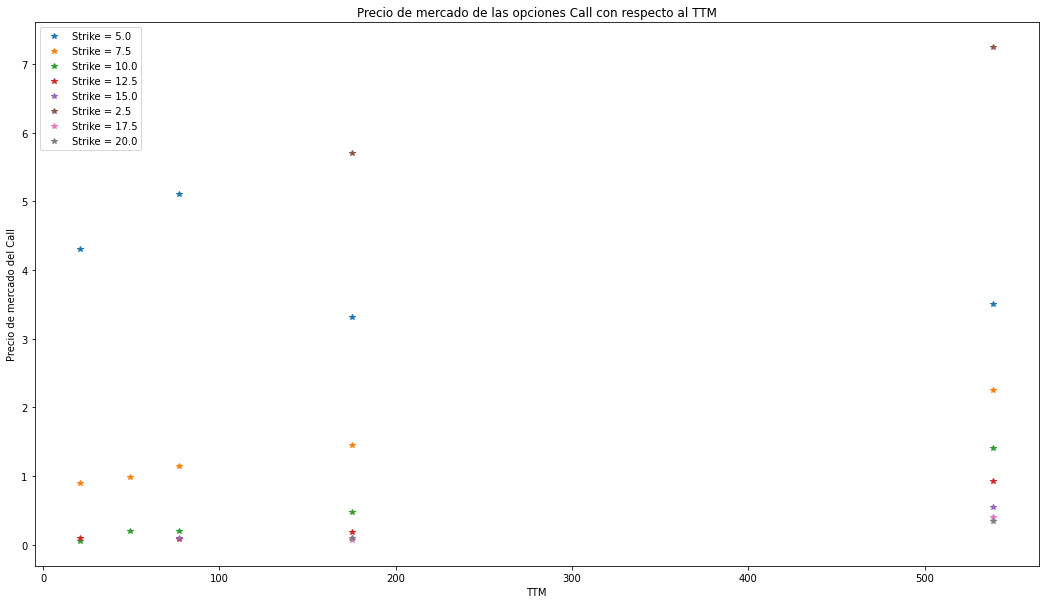

In [9]:
## para cada strike, grafico los calls segun time to maturity y precio
graficar_ttm_precio(ggal,"C")

####  Repito con un ticker más liquido

In [10]:
ticker = "TSLA"
tsla = generar_df_opciones(ticker)
tsla = get_full_data(tsla)

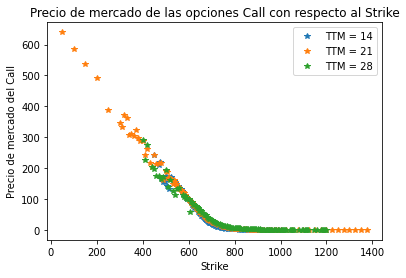

In [11]:
## veamos como es le gráfico de strike contra precio de una accion liquida
## veamos solo los ttms que usa maurette
graficar_strike_precio(tsla,"C", [14, 21,28])

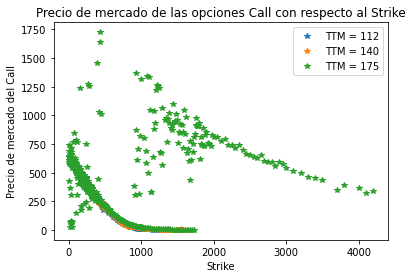

In [12]:
## con otros ttms
graficar_strike_precio(tsla,"C", [112, 140, 175])

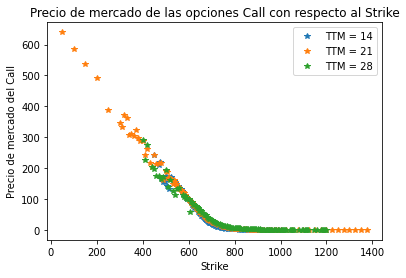

In [13]:
## con otros ttms (distintos)
graficar_strike_precio(tsla,"C", [14, 21, 28])

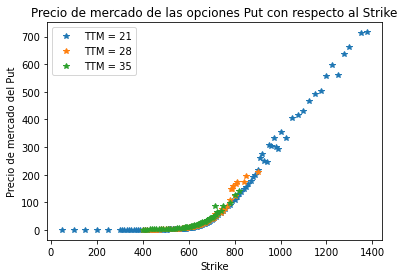

In [14]:
## con puts!
graficar_strike_precio(tsla,"P", [21, 28, 35])

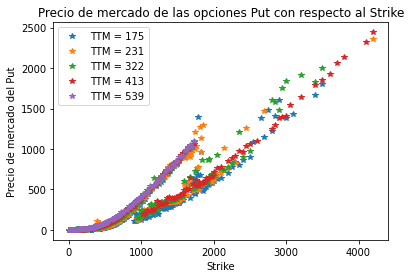

In [15]:
## y otros ttms de puts
graficar_strike_precio(tsla,"P", [175, 231, 322, 413, 539])

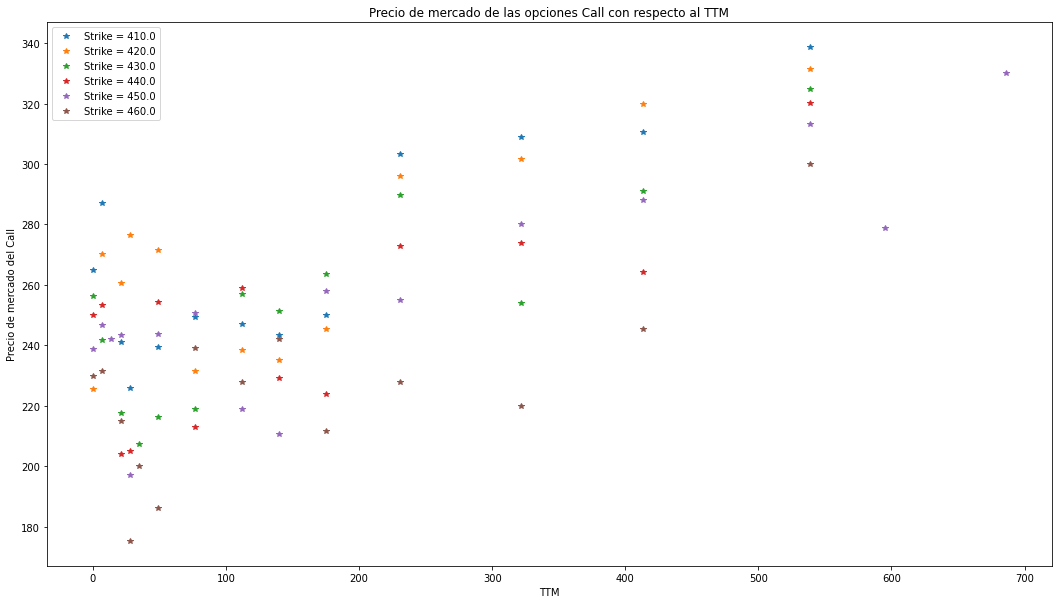

In [16]:
## veamos el gráfico de TTM contra precio (usamos algunos strikes nomas)
graficar_ttm_precio(tsla,"C", Ks= [410., 420., 430., 440., 450., 460.])

### Payoffs y Estrategias 

In [17]:
## define el payoff de un call comun
## el maximo entre S-K y 0 (S sería el spot y K el strike)
## lo mismo para un put: el maximo entre K-S y 0

def payoff_call(S,K):
    return np.maximum(S-K,0)

def payoff_put(S,K):
    return np.maximum(K-S,0)

In [18]:
## define un strike de 50 
## y genera una serie de 50 numeros entre 0 y 100 para el spot
K=50
S = np.linspace(0,100,50)

Text(0.5, 1.0, 'Put')

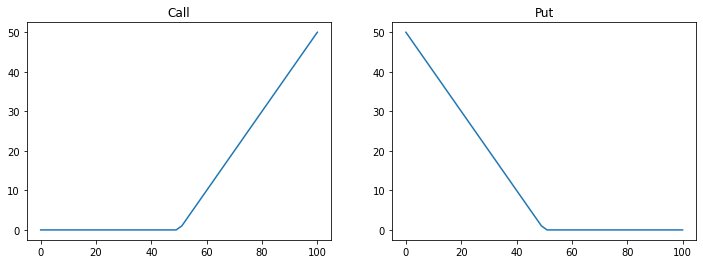

In [19]:
#Grafico la call
## plotea para cada uno de los 50 valores del spot entre 0 y 100 
## el payoff de la opción

## definimos el tamaño del grafico
plt.figure(figsize=(12,4))

## y armamos dos subplots, uno para el call y uno para el put
## hacemos 1 fila, 2 columnas
## grafico 1
plt.subplot(1,2,1)
plt.plot(S,payoff_call(S, K))
plt.title("Call")

## lo mismo para el put
## 1 fila, 2 columnas grafico 2
plt.subplot(1,2,2)
plt.plot(S,payoff_put(S, K))
plt.title("Put")

In [20]:
## define el forward sintético:
## a un call le resta un put
## esto seria como ir long en un call y short en un put

def payoff_forwardSintetico(S,K):
    return payoff_call(S,K)-payoff_put(S, K)

## define un combo con dos strikes (k1 y k2)
## long en un call con strike k2 y short un put con strike k1
def payoff_combo(S,K1,K2):
    return payoff_call(S,K2) - payoff_put(S, K1)


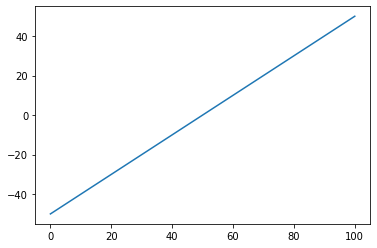

In [21]:
#Grafico el forward sintetico
plt.plot(S,payoff_forwardSintetico(S, K))
plt.show()

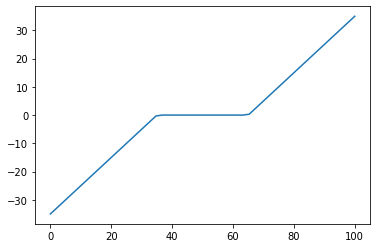

In [22]:
K1 = 35
K2 = 65
#Grafico el combo
plt.plot(S,payoff_combo(S, K1,K2))
plt.show()

In [23]:
## Spreads

## en todos los ejemplos K1 < K2:

## bull call spread: long call con strike K1. short call con strike k2
def payoff_BullCS(S,K1,K2):
    return payoff_call(S,K1)-payoff_call(S, K2)

## bear call spread: long call con strike K2. short call con strike k1
def payoff_BearCS(S,K1,K2):
    return payoff_call(S,K2)-payoff_call(S, K1)

## bull put spread: long put con strike K1. short put con strike k2
def payoff_BullPS(S,K1,K2):
    return payoff_put(S,K1)-payoff_put(S, K2)

## bear put spread: long put con strike K2. short put con strike k1
def payoff_BearPS(S,K1,K2):
    return payoff_put(S,K2)-payoff_put(S, K1)


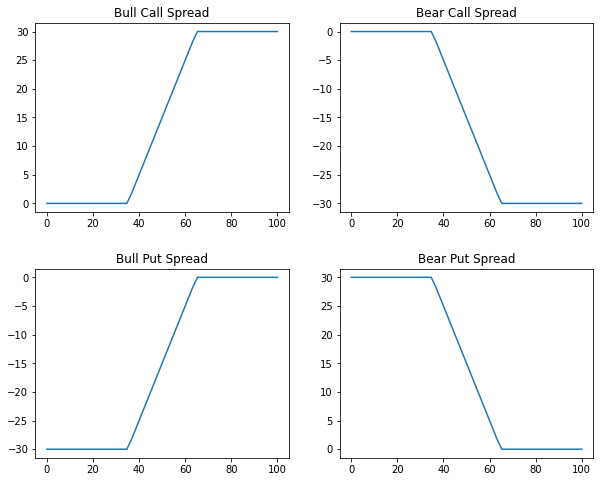

In [24]:
## graficamos los 4:

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.plot(S,payoff_BullCS(S, K1, K2))
plt.title("Bull Call Spread")

plt.subplot(2,2,2)
plt.plot(S,payoff_BearCS(S, K1, K2))
plt.title("Bear Call Spread")

plt.subplot(2,2,3)
plt.plot(S,payoff_BullPS(S, K1, K2))
plt.title("Bull Put Spread")

plt.subplot(2,2,4)
plt.plot(S,payoff_BearPS(S, K1, K2))
plt.title("Bear Put Spread")

plt.subplots_adjust(hspace=.3)

In [25]:
## Butterfly

## call butterfly spread: long call con strike K1, short 2 calls con strike K2, long call con strike K3
def payoff_CButterflyS(S,K1,K2,K3):
    return payoff_call(S,K1)-2*payoff_call(S, K2)+payoff_call(S, K3)

## put butterfly spread: long put con strike K1, short 2 puts con strike K2, long put con strike K3
def payoff_PButterflyS(S,K1,K2,K3):
    return payoff_put(S,K1)-2*payoff_put(S, K2)+payoff_put(S, K3)

Text(0.5, 1.0, 'Put Buterfly Spread')

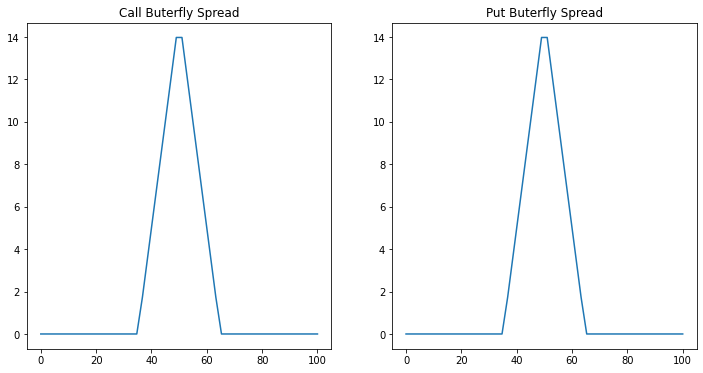

In [26]:
K1=35
K2=50
K3=65

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(S,payoff_CButterflyS(S, K1, K2,K3))
plt.title("Call Buterfly Spread")

plt.subplot(1,2,2)
plt.plot(S,payoff_PButterflyS(S, K1, K2,K3))
plt.title("Put Buterfly Spread")

In [27]:
## straddle: long call y long put con igual strike
def payoff_straddle(S,K):
    return payoff_call(S,K)+payoff_put(S, K)

## strangle: long call y long put con strike distinto
def payoff_strangle(S,K1,K2):
    return payoff_call(S,K1)+payoff_put(S, K2)


Text(0.5, 1.0, 'Straddle')

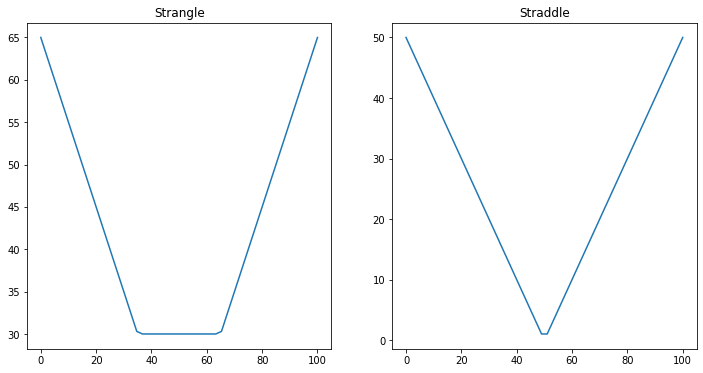

In [28]:
K1 = 35
K2 = 65


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(S,payoff_strangle(S, K1,K2))
plt.title("Strangle")


plt.subplot(1,2,2)
plt.plot(S,payoff_straddle(S, K))
plt.title("Straddle")

In [29]:
## iron condor: long put con strike k1, short put con strike k2, 
## short call con strike k3 long call con strike k4
## k1 < k2 < k3 < k4

def payoff_iron_condor(S,K1,K2,K3,K4):
    return payoff_put(S,K1)-payoff_put(S, K2)-payoff_call(S,K3)+payoff_call(S,K4)

Text(0.5, 1.0, 'Iron Condor')

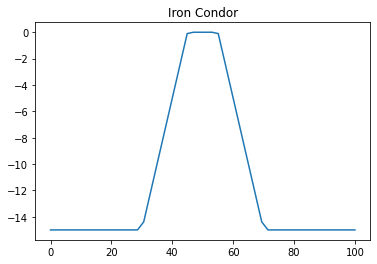

In [30]:
K1 = 30
K2 = 45
K3 = 55
K4 = 70

plt.plot(S,payoff_iron_condor(S, K1,K2,K3,K4))
plt.title("Iron Condor")